This notebook explores the correation between QCEW statistics and LAP-acquired lands statistics.

Done by: Angelia

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# input files
QCEW_FILEPATH = '../data/QCEW_2000-2018_cleaned_naics_sectors.csv'
LAP_COUNTS_FILEPATH = '../data/LAP_annual_counts.csv'
LAP_ACRES_FILEPATH = '../data/LAP_annual_acres.csv'
LAP_ACRES_NORM_FILEPATH = '../data/LAP_annual_acres_normalized.csv'

# constants
WOH_COUNTIES = ['Delaware', 'Greene', 'Schoharie', 'Sullivan', 'Ulster']
EOH_COUNTIES = ['Dutchess', 'Putnam', 'Westchester']
METRICS = ['Real Total Salary', 'Real Average Salary', 'Average Employment', 'Establishments']
TOTAL_INDUSTRIES = ['Total, All Industries', 'Total, All Private', 'Total, All Government']

In [2]:
qcew = pd.read_csv(QCEW_FILEPATH, index_col=0)
qcew.head()

,NAICS,NAICS Title,Year,Establishments,Average Employment,Total Wage,Annual Average Salary,CPI,Real Average Salary,Real Total Salary
County,,,,,,,,,,
Albany,0,"Total, All Industries",2018,10252,233679,1.361919e+10,58282.0,273.641,58282.0,1.361919e+10
Albany,1,"Total, All Private",2018,9813,172969,9.545942e+09,55189.0,273.641,55189.0,9.545942e+09
Albany,11,"Agriculture, Forestry, Fishing and Hunting",2018,17,235,7.986065e+06,33983.0,273.641,33983.0,7.986065e+06
Albany,22,Utilities,2018,11,520,6.750030e+07,129808.0,273.641,129808.0,6.750030e+07
Albany,23,Construction,2018,696,7554,5.878178e+08,77815.0,273.641,77815.0,5.878178e+08


In [3]:
# load LAP Acres
lap_acres = pd.read_csv(LAP_ACRES_FILEPATH, index_col=0)
lap_acres.head()

,Delaware,Dutchess,Greene,Putnam,Schoharie,Sullivan,Ulster,Westchester
year,,,,,,,,
1997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.140498,0.000000
1998,79.339455,52.639110,114.952669,1904.332258,0.000000,448.184119,2494.442626,0.000000
1999,422.136287,278.462069,270.423943,1298.131489,0.000000,141.273826,1528.433320,0.949407
2000,1109.972263,17.611230,25.968306,851.433788,0.000000,322.299167,1580.639026,15.143574
2001,1820.017048,0.000000,410.679083,1466.151928,636.722427,307.663491,1969.480620,312.252120


In [4]:
# years avail for our datasets
print('years avail for qcew:', qcew.Year.min(), '-', qcew.Year.max())
print('years avail for lap:', lap_acres.index.min(), '-', lap_acres.index.max())
common_years = set(qcew.Year).intersection(set(lap_acres.index))
print('common years:', common_years)

years avail for qcew: 2000 - 2018
years avail for lap: 1997 - 2020
common years: {2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018}


In [5]:
# truncate datasets to common years ie 2000-2018
lap_acres = lap_acres[lap_acres.index.isin(common_years)]
qcew = qcew[qcew.Year.isin(common_years)]

# Plot correlation of all industries for each metric

In [14]:
# plot only industries with non-null values
corr_data = []
industries = qcew['NAICS Title'].unique()
        
for industry in industries:
    for category in METRICS:
        # row = year, column = WOH, value = specific industry and metric 
        subset = qcew[(qcew['NAICS Title']==industry) 
                      & qcew.index.isin(lap_acres.columns)]
        qcew_f = subset.pivot_table(index='Year', 
                                    columns='County', 
                                    values=category)
        if qcew_f.isnull().any().any(): # discard this industry for this metric if there are null values
            continue
        
        # calc corr with acres acquired (normalized by county area)
        correlations = qcew_f.corrwith(lap_acres).tolist()
        entry = {cty: correlations[i] for i, cty in enumerate(qcew_f.columns)}
        entry.update({'industry': industry,
                      'metric': category})
        corr_data.append(entry)
        
correlations = pd.DataFrame(corr_data)
correlations.head()

,Delaware,Dutchess,Greene,Putnam,Schoharie,Sullivan,Ulster,Westchester,industry,metric
0,-0.298735,-0.069642,0.187290,-0.505320,-0.008332,-0.092802,-0.684970,0.231889,"Total, All Industries",Real Average Salary
1,0.283432,0.627963,0.278313,-0.709692,-0.047566,-0.249522,0.434040,0.047947,"Total, All Industries",Average Employment
2,0.348588,-0.228960,0.399444,-0.740620,-0.452903,0.364117,-0.682117,-0.091558,"Total, All Industries",Establishments
3,0.166516,0.474783,0.283093,-0.701301,-0.033572,-0.211839,-0.283223,0.144666,"Total, All Industries",Real Total Salary
4,-0.032770,0.197829,0.155133,0.255131,-0.439527,-0.111416,-0.394787,0.572934,"Total, All Private",Real Average Salary


### => Export correlations as json for viz

In [19]:
import json
with open('../output/woh_corr_4.json', 'r') as f:
    data = json.load(f)

In [20]:
lap_acres.index = lap_acres.index.astype('int')

In [21]:
# update json: # metric, landuse, county, {industry: corr_val}
for metric in METRICS: 
    data[metric]['All Landuse Types'] = {}
    for county in WOH_COUNTIES + EOH_COUNTIES:
        # compute correlations
        industry_data = qcew[(qcew.index==county)].pivot(index='Year', 
                                                         columns='NAICS Title', 
                                                         values=metric)
        industry_data = industry_data.dropna(axis='columns', how='any')
        industry_data = industry_data.join(lap_acres[county].to_frame('acres'))
        corr = industry_data.corr().iloc[-1, :-1].to_dict()
        
        # add corr data
        if county not in data[metric]['All Landuse Types']:
            data[metric]['All Landuse Types'][county] = {}
        data[metric]['All Landuse Types'][county] = corr

In [22]:
for item in [data.keys(), 
             data['Real Average Salary'].keys(), 
             data['Real Average Salary']['All Landuse Types'].keys(),
             data['Real Average Salary']['All Landuse Types']['Putnam'].keys()]:
    print(item)
    print()

dict_keys(['Real Total Salary', 'Real Average Salary', 'Average Employment', 'Establishments'])

dict_keys(['Agricultural Land', 'Forest Land', 'Urban/Built-up Land', 'Others', 'All Landuse Types'])

dict_keys(['Delaware', 'Greene', 'Schoharie', 'Sullivan', 'Ulster', 'Dutchess', 'Putnam', 'Westchester'])

dict_keys(['Accommodation and Food Services', 'Administrative and Waste Services', 'Agriculture, Forestry, Fishing and Hunting', 'Arts, Entertainment, and Recreation', 'Construction', 'Educational Services', 'Finance and Insurance', 'Health Care and Social Assistance', 'Information', 'Manufacturing', 'Other Services, Ex. Public Admin', 'Professional and Technical Services', 'Real Estate and Rental and Leasing', 'Retail Trade', 'Total, All Government', 'Total, All Industries', 'Total, All Private', 'Transportation and Warehousing', 'Unclassified', 'Wholesale Trade'])



In [23]:
with open('../output/corr_4.json', 'w') as f:
    json.dump(data, f)


In [38]:
pc_area = {
    'Delaware': .57,
    'Greene': .47,
    'Schoharie': .09,
    'Sullivan': .07,
    'Ulster': .31,
    'Dutchess': .04,
    'Putnam': .59,
    'Westchester': .38
}

sorted_counties = [k for k, v in sorted(pc_area.items(), key=lambda item: item[1])]
sorted_woh = list(filter(lambda c: c in WOH_COUNTIES, sorted_counties))
sorted_eoh = list(filter(lambda c: c in EOH_COUNTIES, sorted_counties))

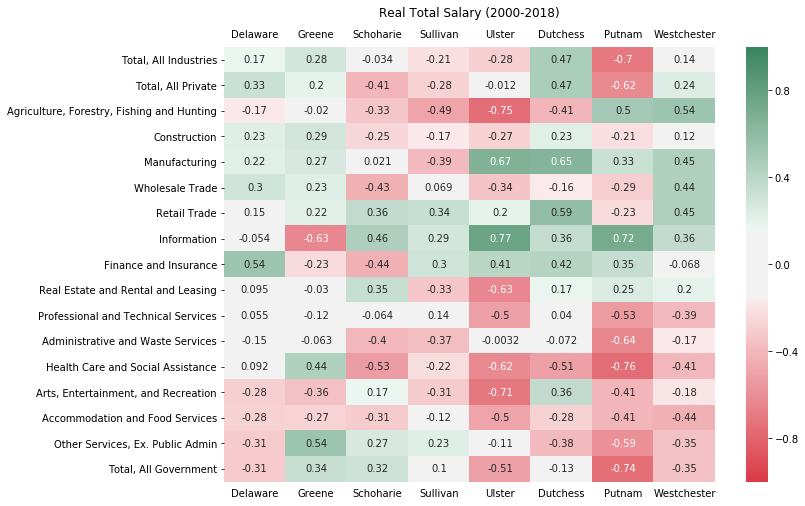

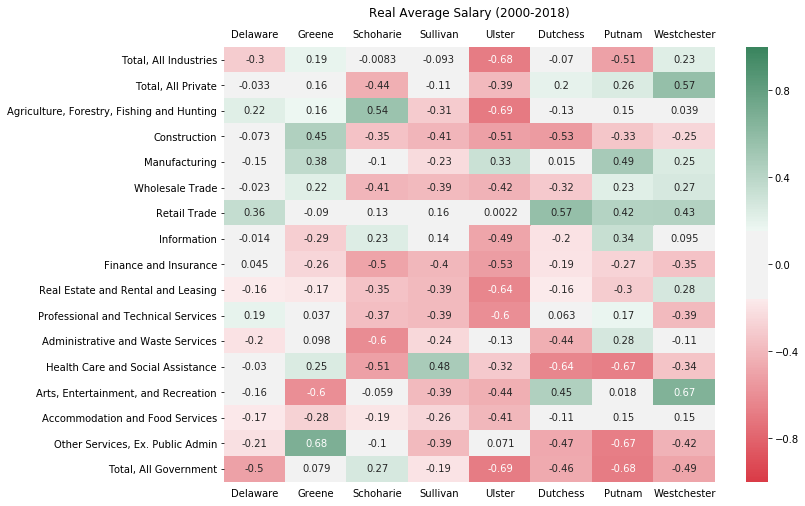

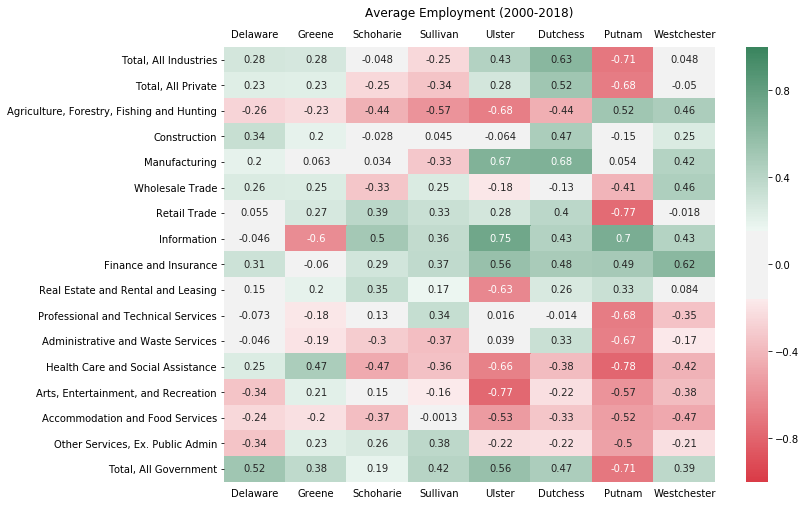

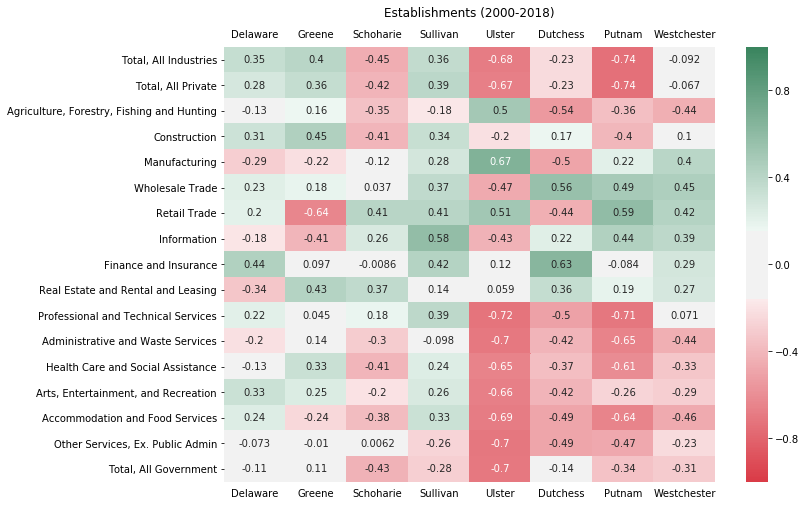

In [24]:
# plot only industries with non-null values
for metric in METRICS:
    qcew_corr = correlations[correlations.metric==metric]\
                .set_index('industry')[sorted_woh+sorted_eoh]
#     qcew_corr = pd.concat([qcew_corr.sort_index().drop(index=TOTAL_INDUSTRIES), qcew_corr.loc[TOTAL_INDUSTRIES]])
    
    _, ax = plt.subplots(figsize=(11,8))
    sns.heatmap(qcew_corr,
                ax=ax,
                vmin=-1,vmax=1,
                center=0, 
                cmap=sns.diverging_palette(10, 145, sep=40, as_cmap=True),
                annot=True)
    ax.set_ylabel('')
    ax.set_title('%s (2000-2018)'%metric, pad=30)
    ax.tick_params(labeltop=True, bottom=False)

In [55]:
labels = {}
for k, v in pc_area.items():
    soh = 'WOH' if k in WOH_COUNTIES else 'EOH'
    labels[k] = f"{soh}\n{k}\n{int(v*100)}%"

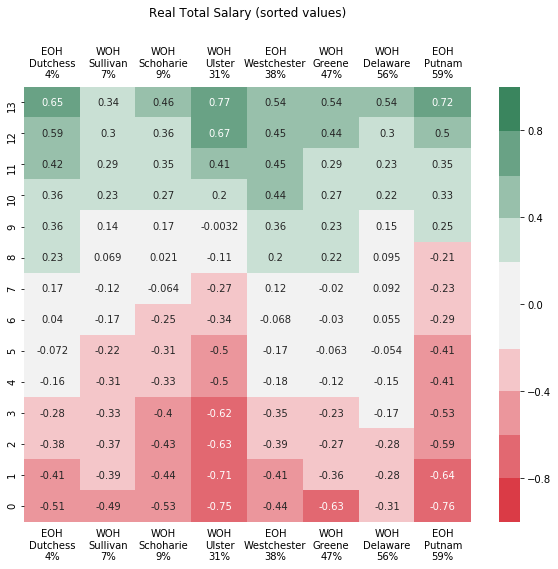

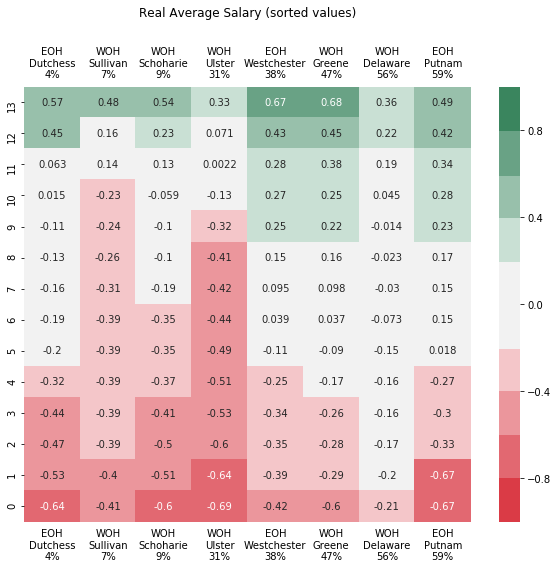

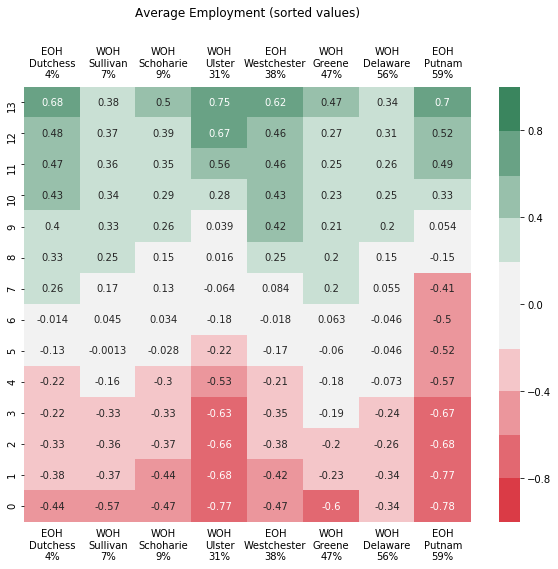

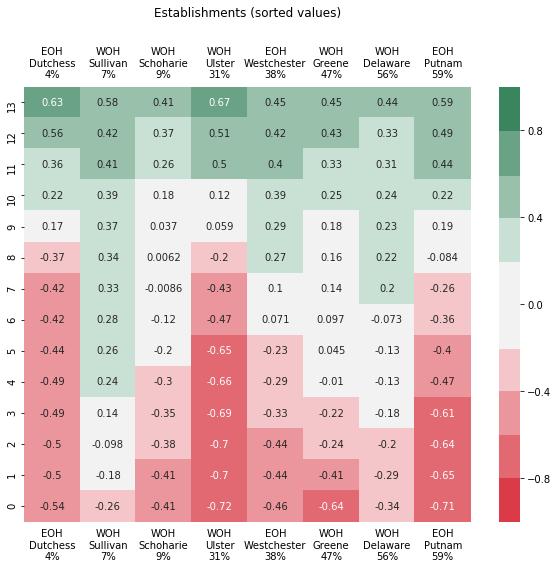

In [56]:
# viz: sort according to value
# _, axes = plt.subplots(2,2, figsize=(10,8), sharex=True, sharey=True)
# axes = axes.flatten()
for i, metric in enumerate(METRICS):
    metric_df = correlations[(correlations.metric==metric) 
                             & ~(correlations.industry.isin(TOTAL_INDUSTRIES))]\
                    [sorted_counties]
    sorted_vals = {}
    for county in metric_df.columns:
        sorted_vals[county] = sorted(metric_df[county].tolist())

    _, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(pd.DataFrame(sorted_vals)[::-1],
                ax=ax,
                vmin=-1,vmax=1,
                center=0, 
                cmap=sns.diverging_palette(10, 145, sep=40, n=10),
                annot=True)
    ax.set_ylabel('')
    ax.set_xticklabels([labels[c] for c in sorted_counties])
    ax.set_title('%s (sorted values)'%metric, pad=30)
    ax.tick_params(labeltop=True, bottom=False)

In [10]:
for metric in METRICS:
    print('===== %s ====='%metric)
    print('==> Max correlations:')
    print(correlations[(correlations.metric==metric) 
                       & ~(correlations.industry.isin(TOTAL_INDUSTRIES))]\
              .set_index('industry')[WOH_COUNTIES+EOH_COUNTIES].idxmax())
    print('\n')
    print('==> Min correlations:')
    print(correlations[(correlations.metric==metric) 
                       & ~(correlations.industry.isin(TOTAL_INDUSTRIES))]\
              .set_index('industry')[WOH_COUNTIES+EOH_COUNTIES].idxmin())
    print('\n\n')

===== Real Average Salary =====
==> Max correlations:
Delaware                                     Retail Trade
Greene                   Other Services, Ex. Public Admin
Schoharie      Agriculture, Forestry, Fishing and Hunting
Sullivan                Health Care and Social Assistance
Ulster                                      Manufacturing
Dutchess                                     Retail Trade
Putnam                                      Manufacturing
Westchester           Arts, Entertainment, and Recreation
dtype: object


==> Min correlations:
Delaware                 Other Services, Ex. Public Admin
Greene                Arts, Entertainment, and Recreation
Schoharie               Administrative and Waste Services
Sullivan                                     Construction
Ulster         Agriculture, Forestry, Fishing and Hunting
Dutchess                Health Care and Social Assistance
Putnam                   Other Services, Ex. Public Admin
Westchester              Other Service

# Plot trendlines for select EOH counties/industries

In [14]:
requests = [{'metric': 'Real Average Salary',
             'county': 'Westchester',
             'industry': 'Arts, Entertainment, and Recreation'
            },
            {'metric': 'Real Average Salary',
             'county': 'Putnam',
             'industry': 'Other Services, Ex. Public Admin'
            },
            {'metric': 'Average Employment',
             'county': 'Putnam',
             'industry': 'Information'
            },
            {'metric': 'Average Employment',
             'county': 'Putnam',
             'industry': 'Health Care and Social Assistance'
            },
            {'metric': 'Establishments',
             'county': 'Dutchess',
             'industry': 'Finance and Insurance'
            },
            {'metric': 'Establishments',
             'county': 'Putnam',
             'industry': 'Professional and Technical Services'
            }]

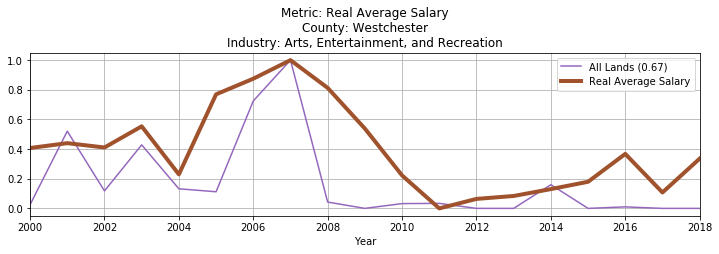

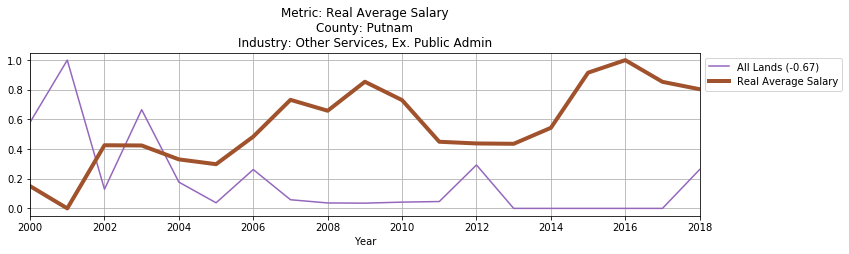

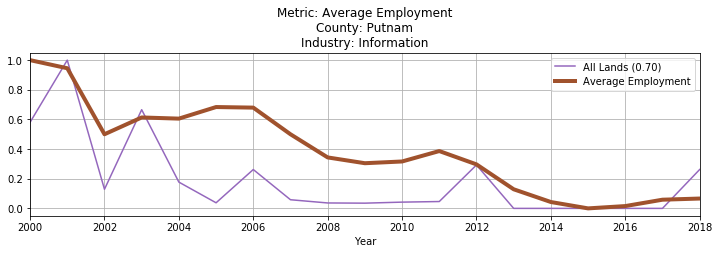

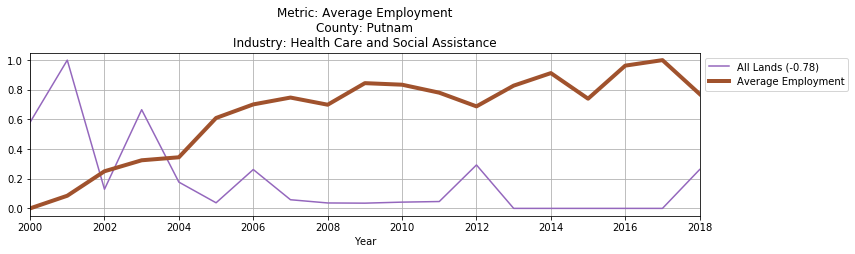

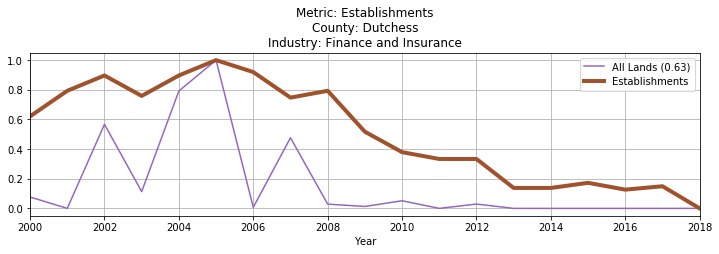

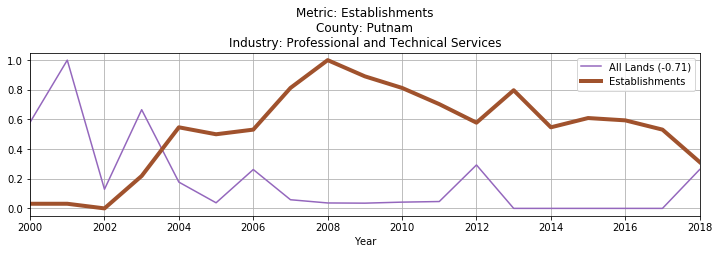

In [25]:
# plot trends for specific correlations
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D

scaler = MinMaxScaler()

for req in requests:
    metric = req['metric']
    county = req['county']
    industry = req['industry']

    ### data wrangling
    # lap data
    subset = lap_acres[[county]].rename(columns={county: 'All Lands'})

    # add economic data to it
    subset = subset.join(qcew[(qcew.index==county) 
                       & (qcew['NAICS Title']==industry)]\
                    .set_index('Year')[[metric]])

    # min max scale the data
    subset = pd.DataFrame(scaler.fit_transform(subset), 
                          columns=subset.columns,
                          index=subset.index)
    labels = ['%s (%.2f)'%pair for pair in subset.corr().iloc[-1, :-1].items()]
    labels.append(metric)

    ### plotting
    # plot lap acres
    title = 'Metric: %s\nCounty: %s\nIndustry: %s'%(metric, county, industry)
    ax = subset.iloc[:, :-1].plot(figsize=(12,3),
                                  title=title, 
                                  color='tab:purple'
                                 )
    # plot economic metric
    subset[metric].plot(ax=ax, linewidth=4, color='sienna')

    plt.legend(labels=labels,
               bbox_to_anchor=(1,1))
    plt.xlabel('Year')
    plt.grid(True)